#기초 세팅

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 47.3 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 9.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595730 sha256=4552735fe9c558734dad93960728b2516d308e0160d1e10034ef43f4f4e01542
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 6.9 MB/s 
     |████████████████████████████████| 769 kB 8.1 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 3.0 MB 53.3 MB/s 


In [2]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-0eql7eg2
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-0eql7eg2
     |████████████████████████████████| 132 kB 7.4 MB/s 
     |████████████████████████████████| 4.5 MB 64.2 MB/s 
     |████████████████████████████████| 3.8 MB 52.8 MB/s 
     |████████████████████████████████| 596 kB 68.5 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 6.5 MB 52.3 MB/s 
     |████████████████████████████████| 79 kB 9.5 MB/s 
     |████████████████████████████████| 8.6 MB 54.7 MB/s 
     |████████████████████████████████| 127 kB 73.5 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=9ee35d9dd4bf57a581c559b344c71eebd890e9a18efbf87bef411acb1952d19c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgozwtl4/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd05

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
torch.cuda.empty_cache()

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용
device = torch.device("cuda:0")

In [6]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Setting

In [8]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/빅데이터 핀테크 전문가/딥러닝 팀프로젝트/data/news_total.csv')

In [9]:
data = data.sample(3000, random_state = 1138)

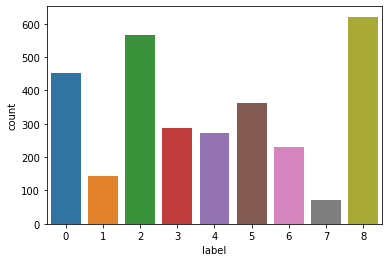

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='label', data=data)
plt.show()

In [11]:
data_list = []
for q, label in zip(data['contents'], data['label'])  :
    temp = []
    temp.append(q)
    temp.append(str(label))

    data_list.append(temp)

In [12]:
from sklearn.model_selection import train_test_split                                               
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

#하이퍼 파라미터 세팅

###batch size 조정

####Batch 1

In [ ]:
max_len = 500
batch_size = 1
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0698578357696533 train acc 0.0
epoch 1 batch id 201 loss 2.0433123111724854 train acc 0.1691542288557214
epoch 1 batch id 401 loss 0.9848083257675171 train acc 0.20199501246882792
epoch 1 batch id 601 loss 2.9247305393218994 train acc 0.21797004991680533
epoch 1 batch id 801 loss 1.0908544063568115 train acc 0.26092384519350814
epoch 1 batch id 1001 loss 3.5594980716705322 train acc 0.2997002997002997
epoch 1 batch id 1201 loss 0.2881317138671875 train acc 0.324729392173189
epoch 1 batch id 1401 loss 2.4331607818603516 train acc 0.35403283369022126
epoch 1 batch id 1601 loss 0.011363428086042404 train acc 0.3885071830106184
epoch 1 batch id 1801 loss 1.549505352973938 train acc 0.4031093836757357
epoch 1 batch id 2001 loss 4.468138694763184 train acc 0.4127936031984008
epoch 1 batch id 2201 loss 0.8603529930114746 train acc 0.41481144934120856
epoch 1 train acc 0.41644444444444445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 1 test acc 0.48133333333333334


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 4.25403356552124 train acc 0.0
epoch 2 batch id 201 loss 0.007641607895493507 train acc 0.46766169154228854
epoch 2 batch id 401 loss 0.02925167605280876 train acc 0.4937655860349127
epoch 2 batch id 601 loss 5.574846267700195 train acc 0.502495840266223
epoch 2 batch id 801 loss 0.011472797952592373 train acc 0.5168539325842697
epoch 2 batch id 1001 loss 3.97013783454895 train acc 0.5134865134865135
epoch 2 batch id 1201 loss 0.008242873474955559 train acc 0.5029142381348876
epoch 2 batch id 1401 loss 6.465302467346191 train acc 0.5189150606709493
epoch 2 batch id 1601 loss 0.0018734062323346734 train acc 0.5246720799500312
epoch 2 batch id 1801 loss 1.9385051727294922 train acc 0.5147140477512493
epoch 2 batch id 2001 loss 5.320679664611816 train acc 0.5162418790604698
epoch 2 batch id 2201 loss 0.035536982119083405 train acc 0.522035438437074
epoch 2 train acc 0.5213333333333333


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 2 test acc 0.568


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.37285202741622925 train acc 1.0
epoch 3 batch id 201 loss 0.005232567898929119 train acc 0.5970149253731343
epoch 3 batch id 401 loss 0.2612691819667816 train acc 0.5685785536159601
epoch 3 batch id 601 loss 6.214650630950928 train acc 0.562396006655574
epoch 3 batch id 801 loss 0.011944438330829144 train acc 0.5667915106117354
epoch 3 batch id 1001 loss 4.204285621643066 train acc 0.5554445554445554
epoch 3 batch id 1201 loss 0.012277268804609776 train acc 0.5403830141548709
epoch 3 batch id 1401 loss 2.2253899574279785 train acc 0.5396145610278372
epoch 3 batch id 1601 loss 4.732120990753174 train acc 0.551530293566521
epoch 3 batch id 1801 loss 1.7725071907043457 train acc 0.5524708495280399
epoch 3 batch id 2001 loss 6.495978832244873 train acc 0.5547226386806596
epoch 3 batch id 2201 loss 0.014662721194326878 train acc 0.5561108587005906
epoch 3 train acc 0.5577777777777778


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 3 test acc 0.532


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.2281510829925537 train acc 1.0
epoch 4 batch id 201 loss 0.01664864458143711 train acc 0.6119402985074627
epoch 4 batch id 401 loss 0.004990383516997099 train acc 0.6109725685785536
epoch 4 batch id 601 loss 2.3110527992248535 train acc 0.6256239600665557
epoch 4 batch id 801 loss 0.0029464424587786198 train acc 0.6217228464419475
epoch 4 batch id 1001 loss 4.277632236480713 train acc 0.5994005994005994
epoch 4 batch id 1201 loss 6.075408935546875 train acc 0.5928393005828476
epoch 4 batch id 1401 loss 2.119438409805298 train acc 0.6017130620985011
epoch 4 batch id 1601 loss 0.0025403392501175404 train acc 0.6114928169893816
epoch 4 batch id 1801 loss 1.562988042831421 train acc 0.6113270405330372
epoch 4 batch id 2001 loss 6.8394389152526855 train acc 0.6121939030484758
epoch 4 batch id 2201 loss 0.012490028515458107 train acc 0.6124488868696047
epoch 4 train acc 0.6142222222222222


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 4 test acc 0.5786666666666667


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.9915797710418701 train acc 1.0
epoch 5 batch id 201 loss 0.003848053514957428 train acc 0.6218905472636815
epoch 5 batch id 401 loss 0.012490028515458107 train acc 0.6259351620947631
epoch 5 batch id 601 loss 2.1542177200317383 train acc 0.6123128119800333
epoch 5 batch id 801 loss 0.0022896521259099245 train acc 0.6079900124843945
epoch 5 batch id 1001 loss 3.631702184677124 train acc 0.6033966033966034
epoch 5 batch id 1201 loss 0.00506261782720685 train acc 0.601165695253955
epoch 5 batch id 1401 loss 2.177919864654541 train acc 0.6188436830835118
epoch 5 batch id 1601 loss 0.0019224273273721337 train acc 0.6252342286071205
epoch 5 batch id 1801 loss 1.0860345363616943 train acc 0.6257634647418101
epoch 5 batch id 2001 loss 1.7648860216140747 train acc 0.6226886556721639
epoch 5 batch id 2201 loss 0.009859198704361916 train acc 0.6215356656065425
epoch 5 train acc 0.6217777777777778


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 5 test acc 0.572


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.5972727537155151 train acc 1.0
epoch 6 batch id 201 loss 0.003448850242421031 train acc 0.6417910447761194
epoch 6 batch id 401 loss 0.004993111826479435 train acc 0.6408977556109726
epoch 6 batch id 601 loss 3.633512020111084 train acc 0.6306156405990017
epoch 6 batch id 801 loss 0.003568473504856229 train acc 0.6379525593008739
epoch 6 batch id 1001 loss 4.6200690269470215 train acc 0.6303696303696303
epoch 6 batch id 1201 loss 0.006586864124983549 train acc 0.6328059950041632
epoch 6 batch id 1401 loss 1.6334609985351562 train acc 0.6452533904354033
epoch 6 batch id 1601 loss 0.003460373729467392 train acc 0.6489693941286696
epoch 6 batch id 1801 loss 1.1465964317321777 train acc 0.648528595224875
epoch 6 batch id 2001 loss 5.307445526123047 train acc 0.6526736631684158
epoch 6 batch id 2201 loss 0.009449162520468235 train acc 0.6537937301226715
epoch 6 train acc 0.6551111111111111


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 6 test acc 0.6506666666666666


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.923562228679657 train acc 1.0
epoch 7 batch id 201 loss 0.0051826415583491325 train acc 0.7014925373134329
epoch 7 batch id 401 loss 0.003075276967138052 train acc 0.6882793017456359
epoch 7 batch id 601 loss 5.239848613739014 train acc 0.6938435940099834
epoch 7 batch id 801 loss 0.0025699466932564974 train acc 0.6878901373283396
epoch 7 batch id 1001 loss 6.168927192687988 train acc 0.6663336663336663
epoch 7 batch id 1201 loss 0.0015238827327266335 train acc 0.6627810158201499
epoch 7 batch id 1401 loss 2.2758305072784424 train acc 0.668807994289793
epoch 7 batch id 1601 loss 0.00637876708060503 train acc 0.6752029981261711
epoch 7 batch id 1801 loss 1.3961671590805054 train acc 0.6690727373681288
epoch 7 batch id 2001 loss 5.337519645690918 train acc 0.6691654172913544
epoch 7 batch id 2201 loss 0.009964484721422195 train acc 0.6701499318491595
epoch 7 train acc 0.6715555555555556


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 7 test acc 0.6306666666666667


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.8582071661949158 train acc 1.0
epoch 8 batch id 201 loss 0.008736246265470982 train acc 0.7213930348258707
epoch 8 batch id 401 loss 0.003457641461864114 train acc 0.7331670822942643
epoch 8 batch id 601 loss 5.832396507263184 train acc 0.7304492512479202
epoch 8 batch id 801 loss 0.0030005217995494604 train acc 0.7378277153558053
epoch 8 batch id 1001 loss 3.5899174213409424 train acc 0.7192807192807192
epoch 8 batch id 1201 loss 0.0034445736091583967 train acc 0.7152373022481265
epoch 8 batch id 1401 loss 2.0842652320861816 train acc 0.7209136331192005
epoch 8 batch id 1601 loss 0.006058305036276579 train acc 0.722048719550281
epoch 8 batch id 1801 loss 1.806553840637207 train acc 0.7151582454192116
epoch 8 batch id 2001 loss 5.5867156982421875 train acc 0.7141429285357321
epoch 8 batch id 2201 loss 0.00862208567559719 train acc 0.7119491140390731
epoch 8 train acc 0.7128888888888889


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 8 test acc 0.636


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.367990255355835 train acc 1.0
epoch 9 batch id 201 loss 0.001687889569438994 train acc 0.7611940298507462
epoch 9 batch id 401 loss 0.0016312400111928582 train acc 0.7556109725685786
epoch 9 batch id 601 loss 7.358636856079102 train acc 0.7504159733777038
epoch 9 batch id 801 loss 0.00486179580911994 train acc 0.7490636704119851
epoch 9 batch id 1001 loss 3.542874336242676 train acc 0.7392607392607392
epoch 9 batch id 1201 loss 0.004112240858376026 train acc 0.7368859283930058
epoch 9 batch id 1401 loss 2.2480993270874023 train acc 0.7437544610992148
epoch 9 batch id 1601 loss 0.002601455431431532 train acc 0.7432854465958776
epoch 9 batch id 1801 loss 1.491520643234253 train acc 0.7368128817323709
epoch 9 batch id 2001 loss 6.584661960601807 train acc 0.7361319340329835
epoch 9 batch id 2201 loss 0.0037488911766558886 train acc 0.7333030440708769
epoch 9 train acc 0.732


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 9 test acc 0.6333333333333333


  0%|          | 0/2250 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.8608121871948242 train acc 1.0
epoch 10 batch id 201 loss 0.003739984007552266 train acc 0.7512437810945274
epoch 10 batch id 401 loss 0.0036669413093477488 train acc 0.7605985037406484
epoch 10 batch id 601 loss 7.507919788360596 train acc 0.7554076539101497
epoch 10 batch id 801 loss 0.002063408959656954 train acc 0.7578027465667915
epoch 10 batch id 1001 loss 4.268002986907959 train acc 0.7462537462537463
epoch 10 batch id 1201 loss 0.002766355639323592 train acc 0.7443796835970025
epoch 10 batch id 1401 loss 2.795121908187866 train acc 0.7473233404710921
epoch 10 batch id 1601 loss 0.004530878737568855 train acc 0.7520299812617114
epoch 10 batch id 1801 loss 1.2558523416519165 train acc 0.747917823431427
epoch 10 batch id 2001 loss 5.848443031311035 train acc 0.7451274362818591
epoch 10 batch id 2201 loss 0.005190468393266201 train acc 0.745115856428896
epoch 10 train acc 0.7444444444444445


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 10 test acc 0.636


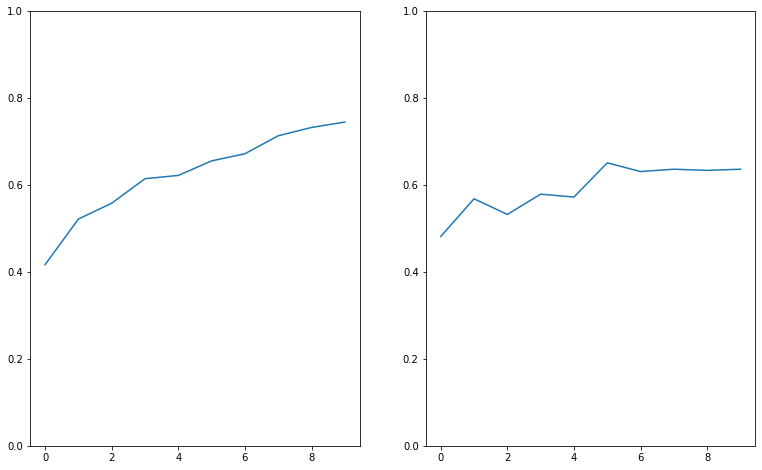

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.41644444444444445, 0.5213333333333333, 0.5577777777777778, 0.6142222222222222, 0.6217777777777778, 0.6551111111111111, 0.6715555555555556, 0.7128888888888889, 0.732, 0.7444444444444445]
[0.48133333333333334, 0.568, 0.532, 0.5786666666666667, 0.572, 0.6506666666666666, 0.6306666666666667, 0.636, 0.6333333333333333, 0.636]


####Batch 3

In [ ]:
max_len = 500
batch_size = 3
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.5227344036102295 train acc 0.0
epoch 1 batch id 201 loss 1.8094888925552368 train acc 0.25704809286898844
epoch 1 batch id 401 loss 0.6173399686813354 train acc 0.44721529509559416
epoch 1 batch id 601 loss 0.6882782578468323 train acc 0.5202440377149192
epoch 1 train acc 0.5386666666666674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 1 test acc 0.5853333333333335


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3973716497421265 train acc 0.3333333333333333
epoch 2 batch id 201 loss 1.4571294784545898 train acc 0.6948590381426205
epoch 2 batch id 401 loss 0.040961939841508865 train acc 0.6874480465502905
epoch 2 batch id 601 loss 1.679996132850647 train acc 0.6927343316694409
epoch 2 train acc 0.6911111111111128


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 2 test acc 0.6079999999999999


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.0674657821655273 train acc 0.6666666666666666
epoch 3 batch id 201 loss 2.977609634399414 train acc 0.6849087893864015
epoch 3 batch id 401 loss 0.03992290794849396 train acc 0.666666666666666
epoch 3 batch id 601 loss 0.835486888885498 train acc 0.6683305601774828
epoch 3 train acc 0.6715555555555576


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 3 test acc 0.5973333333333337


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.0422173738479614 train acc 0.6666666666666666
epoch 4 batch id 201 loss 3.3580710887908936 train acc 0.6965174129353235
epoch 4 batch id 401 loss 0.017983688041567802 train acc 0.7032418952618454
epoch 4 batch id 601 loss 0.32640066742897034 train acc 0.6982806433721584
epoch 4 train acc 0.6986666666666682


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 4 test acc 0.6306666666666667


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.383952260017395 train acc 0.3333333333333333
epoch 5 batch id 201 loss 3.3811023235321045 train acc 0.7114427860696516
epoch 5 batch id 401 loss 0.059847548604011536 train acc 0.7073981712385703
epoch 5 batch id 601 loss 0.4501504898071289 train acc 0.7093732667775942
epoch 5 train acc 0.7164444444444457


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 5 test acc 0.6479999999999999


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.0986872911453247 train acc 0.6666666666666666
epoch 6 batch id 201 loss 2.5396974086761475 train acc 0.7396351575456057
epoch 6 batch id 401 loss 0.04118591547012329 train acc 0.7389858686616799
epoch 6 batch id 601 loss 0.5397858023643494 train acc 0.7437603993344447
epoch 6 train acc 0.7435555555555564


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 6 test acc 0.6373333333333335


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 1.2505559921264648 train acc 0.6666666666666666
epoch 7 batch id 201 loss 2.4546756744384766 train acc 0.7595356550580432
epoch 7 batch id 401 loss 0.01963106356561184 train acc 0.7614297589359936
epoch 7 batch id 601 loss 0.5573061108589172 train acc 0.7603993344425977
epoch 7 train acc 0.7595555555555563


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 7 test acc 0.6253333333333335


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 1.3586841821670532 train acc 0.3333333333333333
epoch 8 batch id 201 loss 1.660570740699768 train acc 0.7777777777777777
epoch 8 batch id 401 loss 0.011644319631159306 train acc 0.7763923524522034
epoch 8 batch id 601 loss 0.49465513229370117 train acc 0.7753743760399359
epoch 8 train acc 0.7760000000000008


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 8 test acc 0.6360000000000001


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.182546854019165 train acc 0.6666666666666666
epoch 9 batch id 201 loss 1.539696216583252 train acc 0.7960199004975123
epoch 9 batch id 401 loss 0.010611350648105145 train acc 0.787198669991688
epoch 9 batch id 601 loss 0.5142799615859985 train acc 0.7864669994453711
epoch 9 train acc 0.784000000000001


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 9 test acc 0.6400000000000002


  0%|          | 0/750 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 1.2045260667800903 train acc 0.3333333333333333
epoch 10 batch id 201 loss 1.575779914855957 train acc 0.7927031509121059
epoch 10 batch id 401 loss 0.01592988520860672 train acc 0.7946799667497928
epoch 10 batch id 601 loss 0.6593945622444153 train acc 0.7920133111480889
epoch 10 train acc 0.7920000000000006


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 10 test acc 0.6426666666666668


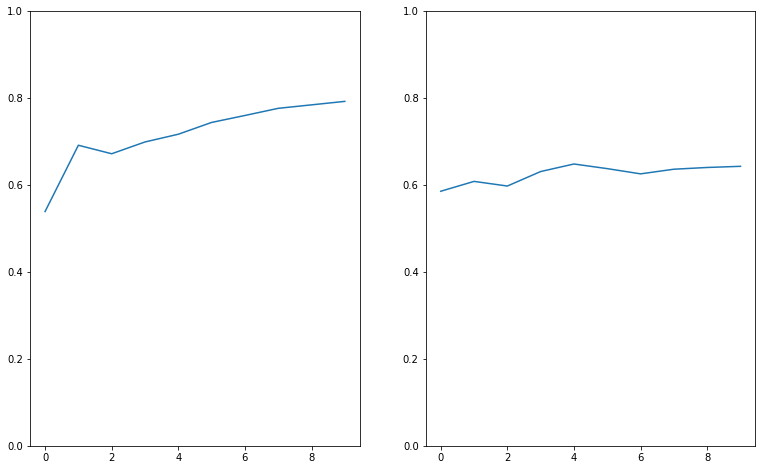

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.5386666666666674, 0.6911111111111128, 0.6715555555555576, 0.6986666666666682, 0.7164444444444457, 0.7435555555555564, 0.7595555555555563, 0.7760000000000008, 0.784000000000001, 0.7920000000000006]
[0.5853333333333335, 0.6079999999999999, 0.5973333333333337, 0.6306666666666667, 0.6479999999999999, 0.6373333333333335, 0.6253333333333335, 0.6360000000000001, 0.6400000000000002, 0.6426666666666668]


####Batch 5

In [ ]:
max_len = 500
batch_size = 5
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/450 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.1468546390533447 train acc 0.2
epoch 1 batch id 201 loss 1.6543395519256592 train acc 0.41990049751243735
epoch 1 batch id 401 loss 0.4986514151096344 train acc 0.5830423940149633
epoch 1 train acc 0.6044444444444455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 1 test acc 0.6333333333333327


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8549192547798157 train acc 0.8
epoch 2 batch id 201 loss 1.7829434871673584 train acc 0.7691542288557213
epoch 2 batch id 401 loss 1.3153419494628906 train acc 0.7566084788029943
epoch 2 train acc 0.7573333333333356


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 2 test acc 0.6413333333333326


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8088465929031372 train acc 0.8
epoch 3 batch id 201 loss 2.985952854156494 train acc 0.7233830845771138
epoch 3 batch id 401 loss 0.4717690050601959 train acc 0.7291770573566099
epoch 3 train acc 0.7280000000000022


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 3 test acc 0.5826666666666663


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.3709683418273926 train acc 0.6
epoch 4 batch id 201 loss 3.200087070465088 train acc 0.7482587064676611
epoch 4 batch id 401 loss 0.3936437964439392 train acc 0.756608478802995
epoch 4 train acc 0.7613333333333364


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 4 test acc 0.630666666666666


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.8414899110794067 train acc 0.8
epoch 5 batch id 201 loss 1.731572151184082 train acc 0.7960199004975123
epoch 5 batch id 401 loss 0.2699580788612366 train acc 0.7820448877805513
epoch 5 train acc 0.7831111111111143


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 5 test acc 0.6279999999999994


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.7477126121520996 train acc 0.6
epoch 6 batch id 201 loss 2.2488744258880615 train acc 0.7731343283582084
epoch 6 batch id 401 loss 0.37778377532958984 train acc 0.7715710723192042
epoch 6 train acc 0.7728888888888917


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 6 test acc 0.6279999999999993


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.5912579298019409 train acc 0.8
epoch 7 batch id 201 loss 1.725079894065857 train acc 0.7920398009950251
epoch 7 batch id 401 loss 0.3423950970172882 train acc 0.7895261845386561
epoch 7 train acc 0.7915555555555588


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 7 test acc 0.6279999999999993


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.6823452711105347 train acc 0.8
epoch 8 batch id 201 loss 2.001466751098633 train acc 0.7940298507462686
epoch 8 batch id 401 loss 0.3160691559314728 train acc 0.8019950124688301
epoch 8 train acc 0.8017777777777804


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 8 test acc 0.6439999999999994


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.7053105235099792 train acc 0.8
epoch 9 batch id 201 loss 1.6805956363677979 train acc 0.8019900497512441
epoch 9 batch id 401 loss 0.3100334405899048 train acc 0.8079800498753145
epoch 9 train acc 0.8075555555555587


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 9 test acc 0.6453333333333328


  0%|          | 0/450 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.7270464897155762 train acc 0.8
epoch 10 batch id 201 loss 1.3720136880874634 train acc 0.8129353233830846
epoch 10 batch id 401 loss 0.3061903119087219 train acc 0.8174563591022467
epoch 10 train acc 0.8164444444444474


  0%|          | 0/150 [00:00<?, ?it/s]

epoch 10 test acc 0.6466666666666661


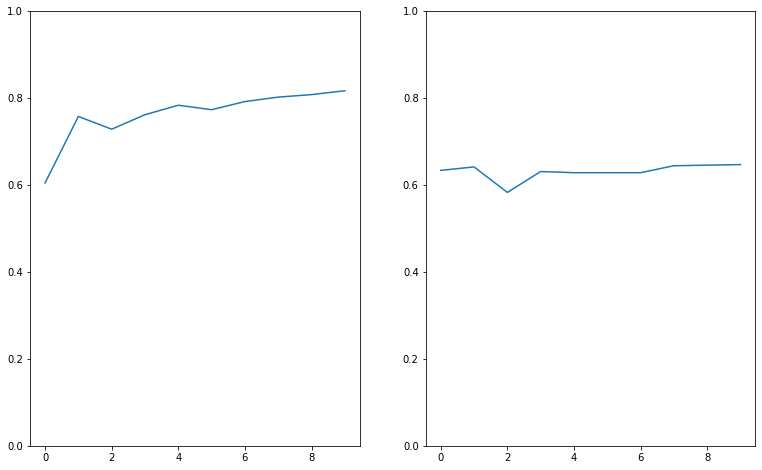

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.6044444444444455, 0.7573333333333356, 0.7280000000000022, 0.7613333333333364, 0.7831111111111143, 0.7728888888888917, 0.7915555555555588, 0.8017777777777804, 0.8075555555555587, 0.8164444444444474]
[0.6333333333333327, 0.6413333333333326, 0.5826666666666663, 0.630666666666666, 0.6279999999999994, 0.6279999999999993, 0.6279999999999993, 0.6439999999999994, 0.6453333333333328, 0.6466666666666661]


####Batch 7

In [ ]:
max_len = 500
batch_size = 7
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.248495578765869 train acc 0.14285714285714285
epoch 1 batch id 201 loss 1.988067865371704 train acc 0.292821606254442
epoch 1 train acc 0.3991422656018926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.6071428571428571


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3393152952194214 train acc 0.5714285714285714
epoch 2 batch id 201 loss 1.9488991498947144 train acc 0.6140724946695091
epoch 2 train acc 0.6280686187518497


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.6375661375661371


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7206655740737915 train acc 0.8571428571428571
epoch 3 batch id 201 loss 1.8458207845687866 train acc 0.6922530206112294
epoch 3 train acc 0.6992014196983157


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6798941798941798


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.37361451983451843 train acc 0.8571428571428571
epoch 4 batch id 201 loss 1.0997005701065063 train acc 0.7654584221748407
epoch 4 train acc 0.7701863354037288


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.6984126984126982


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.35103800892829895 train acc 0.8571428571428571
epoch 5 batch id 201 loss 1.1075537204742432 train acc 0.8059701492537318
epoch 5 train acc 0.8016858917480052


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.6759259259259255


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.36246445775032043 train acc 0.8571428571428571
epoch 6 batch id 201 loss 0.8612862825393677 train acc 0.8336886993603421
epoch 6 train acc 0.8362910381543938


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 6 test acc 0.7275132275132271


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.36389413475990295 train acc 0.8571428571428571
epoch 7 batch id 201 loss 0.7601075172424316 train acc 0.8699360341151394
epoch 7 train acc 0.8660159716060344


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 7 test acc 0.7248677248677245


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.336582213640213 train acc 0.8571428571428571
epoch 8 batch id 201 loss 0.38395556807518005 train acc 0.9097370291400148
epoch 8 train acc 0.9063886424134869


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 8 test acc 0.7222222222222217


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.590512216091156 train acc 0.8571428571428571
epoch 9 batch id 201 loss 0.11958067864179611 train acc 0.9296375266524526
epoch 9 train acc 0.9303460514640635


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 9 test acc 0.7288359788359786


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.3724946975708008 train acc 0.8571428571428571
epoch 10 batch id 201 loss 0.16116760671138763 train acc 0.9402985074626872
epoch 10 train acc 0.9387755102040809


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 10 test acc 0.7275132275132272


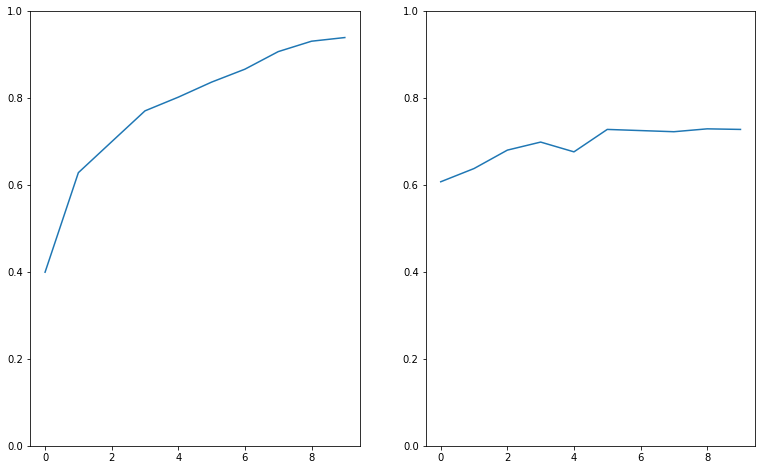

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.3991422656018926, 0.6280686187518497, 0.6992014196983157, 0.7701863354037288, 0.8016858917480052, 0.8362910381543938, 0.8660159716060344, 0.9063886424134869, 0.9303460514640635, 0.9387755102040809]
[0.6071428571428571, 0.6375661375661371, 0.6798941798941798, 0.6984126984126982, 0.6759259259259255, 0.7275132275132271, 0.7248677248677245, 0.7222222222222217, 0.7288359788359786, 0.7275132275132272]


####Batch 10

In [ ]:
max_len = 500
batch_size = 10
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/225 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.1583309173583984 train acc 0.0
epoch 1 batch id 201 loss 1.0957478284835815 train acc 0.3597014925373135
epoch 1 train acc 0.38000000000000006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/75 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

###Epochs

####Max Len : 100

In [ ]:
max_len = 100
batch_size = 7
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517,   3], dtype=int32),
 array(100, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 5)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.1456634998321533 train acc 0.14285714285714285
epoch 1 batch id 201 loss 1.4096221923828125 train acc 0.2622601279317695
epoch 1 train acc 0.37607216799763377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.6560846560846556


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2793227434158325 train acc 0.7142857142857143
epoch 2 batch id 201 loss 1.4658716917037964 train acc 0.6240227434257276
epoch 2 train acc 0.6579414374445441


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.6547619047619045


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.63789302110672 train acc 0.7142857142857143
epoch 3 batch id 201 loss 1.6291252374649048 train acc 0.7540867093105901
epoch 3 train acc 0.7701863354037286


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6785714285714284


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.44804972410202026 train acc 0.8571428571428571
epoch 4 batch id 201 loss 1.5291621685028076 train acc 0.8187633262260133
epoch 4 train acc 0.8283052351375347


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.7076719576719577


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.37040820717811584 train acc 0.8571428571428571
epoch 5 batch id 201 loss 0.8514744639396667 train acc 0.8734896943852173
epoch 5 train acc 0.8775510204081636


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.708994708994709


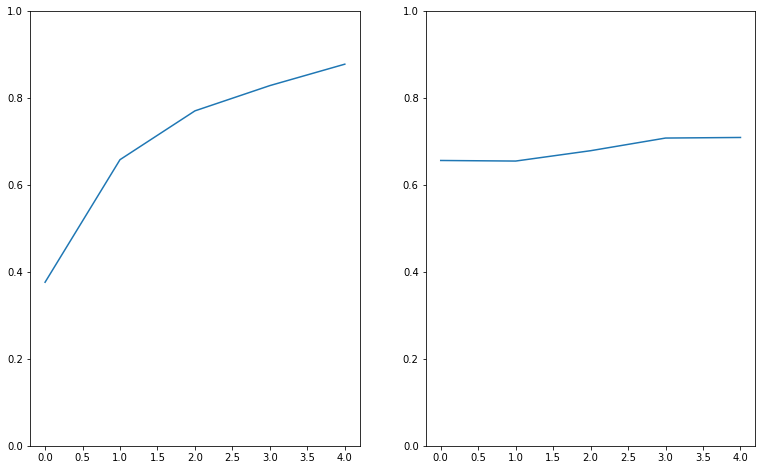

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.37607216799763377, 0.6579414374445441, 0.7701863354037286, 0.8283052351375347, 0.8775510204081636]
[0.6560846560846556, 0.6547619047619045, 0.6785714285714284, 0.7076719576719577, 0.708994708994709]


####Max Len : 350

In [ ]:
max_len = 350
batch_size = 7
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.4033467769622803 train acc 0.0
epoch 1 batch id 201 loss 2.151078939437866 train acc 0.1840796019900497
epoch 1 train acc 0.310411120970127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.5767195767195764


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0666429996490479 train acc 0.7142857142857143
epoch 2 batch id 201 loss 1.3151063919067383 train acc 0.648898365316275
epoch 2 train acc 0.6814551907719626


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.6058201058201056


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.34332746267318726 train acc 1.0
epoch 3 batch id 201 loss 2.1197168827056885 train acc 0.7860696517412937
epoch 3 train acc 0.7919254658385113


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6957671957671956


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.4910261332988739 train acc 0.8571428571428571
epoch 4 batch id 201 loss 0.9589341878890991 train acc 0.847903340440655
epoch 4 train acc 0.848269742679682


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.7103174603174601


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.45271971821784973 train acc 0.8571428571428571
epoch 5 batch id 201 loss 0.7868238091468811 train acc 0.8862828713574987
epoch 5 train acc 0.885980479148181


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.7103174603174602


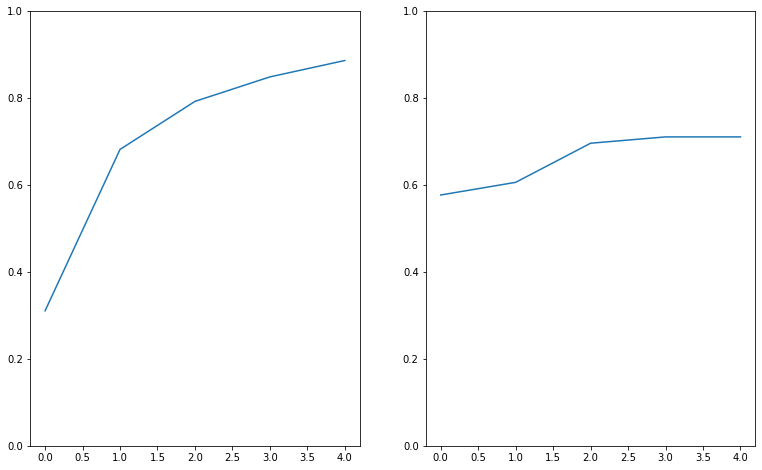

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.310411120970127, 0.6814551907719626, 0.7919254658385113, 0.848269742679682, 0.885980479148181]
[0.5767195767195764, 0.6058201058201056, 0.6957671957671956, 0.7103174603174601, 0.7103174603174602]


####Max Len : 512

In [ ]:
max_len = 512
batch_size = 7
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.4174885749816895 train acc 0.0
epoch 1 batch id 201 loss 2.0862088203430176 train acc 0.2963752665245201
epoch 1 train acc 0.40195208518189857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.6137566137566133


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2575023174285889 train acc 0.5714285714285714
epoch 2 batch id 201 loss 1.4058688879013062 train acc 0.6254442075337593
epoch 2 train acc 0.6503992901508442


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.6759259259259254


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6220717430114746 train acc 0.8571428571428571
epoch 3 batch id 201 loss 1.4221153259277344 train acc 0.724946695095949
epoch 3 train acc 0.7311446317657516


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6997354497354495


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.37091779708862305 train acc 0.8571428571428571
epoch 4 batch id 201 loss 1.2955186367034912 train acc 0.7874911158493253
epoch 4 train acc 0.7910381543921939


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.7023809523809523


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.3215664029121399 train acc 0.8571428571428571
epoch 5 batch id 201 loss 0.868015468120575 train acc 0.827292110874201
epoch 5 train acc 0.8287488908606935


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.7156084656084656


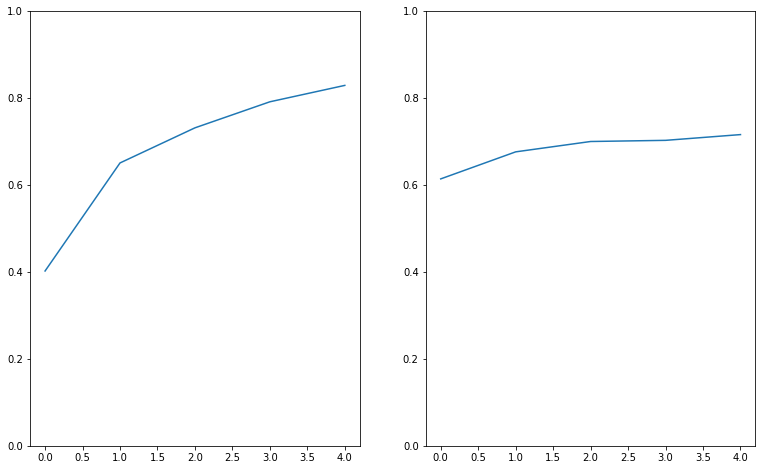

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.40195208518189857, 0.6503992901508442, 0.7311446317657516, 0.7910381543921939, 0.8287488908606935]
[0.6137566137566133, 0.6759259259259254, 0.6997354497354495, 0.7023809523809523, 0.7156084656084656]


####Max Len : 400(EPOCHS = 10)

In [ ]:
max_len = 400
batch_size = 7
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.428607940673828 train acc 0.0
epoch 1 batch id 201 loss 1.6780035495758057 train acc 0.308457711442786
epoch 1 train acc 0.4128955930198164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.6058201058201057


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0009485483169556 train acc 0.7142857142857143
epoch 2 batch id 201 loss 1.6268364191055298 train acc 0.6233120113717128
epoch 2 train acc 0.6418219461697734


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.665343915343915


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5377262234687805 train acc 0.8571428571428571
epoch 3 batch id 201 loss 1.7831532955169678 train acc 0.7057569296375266
epoch 3 train acc 0.713398402839398


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6917989417989412


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.3233843147754669 train acc 1.0
epoch 4 batch id 201 loss 1.4676810503005981 train acc 0.7818052594172004
epoch 4 train acc 0.7857142857142877


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.6984126984126983


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.3927963078022003 train acc 0.8571428571428571
epoch 5 batch id 201 loss 1.8688441514968872 train acc 0.8123667377398726
epoch 5 train acc 0.8212067435669939


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.7208994708994706


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.4357473850250244 train acc 0.8571428571428571
epoch 6 batch id 201 loss 2.0610029697418213 train acc 0.8535891968727795
epoch 6 train acc 0.8518189884649521


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 6 test acc 0.7301587301587298


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.34763914346694946 train acc 0.8571428571428571
epoch 7 batch id 201 loss 0.7750220894813538 train acc 0.8848614072494675
epoch 7 train acc 0.8819875776397522


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 7 test acc 0.7235449735449734


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.29762059450149536 train acc 0.8571428571428571
epoch 8 batch id 201 loss 0.7435280084609985 train acc 0.9090262970859989
epoch 8 train acc 0.905944986690328


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 8 test acc 0.7275132275132277


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.028684694319963455 train acc 1.0
epoch 9 batch id 201 loss 0.4933161735534668 train acc 0.9246624022743432
epoch 9 train acc 0.9201419698314112


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 9 test acc 0.7288359788359787


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.012021288275718689 train acc 1.0
epoch 10 batch id 201 loss 0.41609445214271545 train acc 0.9417199715707185
epoch 10 train acc 0.9361135758651287


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 10 test acc 0.7341269841269842


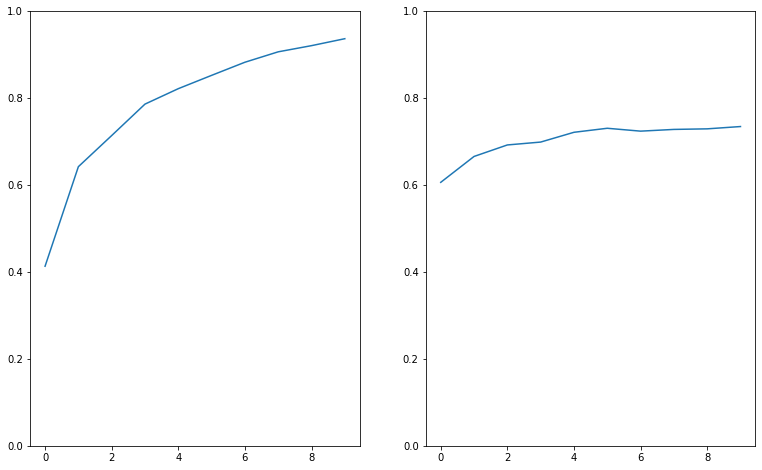

In [ ]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [ ]:
print(train_acc_list)
print(test_acc_list)

[0.4128955930198164, 0.6418219461697734, 0.713398402839398, 0.7857142857142877, 0.8212067435669939, 0.8518189884649521, 0.8819875776397522, 0.905944986690328, 0.9201419698314112, 0.9361135758651287]
[0.6058201058201057, 0.665343915343915, 0.6917989417989412, 0.6984126984126983, 0.7208994708994706, 0.7301587301587298, 0.7235449735449734, 0.7275132275132277, 0.7288359788359787, 0.7341269841269842]


####Max Len : 450(EPOCHS = 10)

In [14]:
max_len = 450
batch_size = 7
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [15]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [16]:
data_train[0]

(array([  2, 687, 264, 302, 351, 681, 342, 282, 359, 517,  46, 687, 358,
        305, 361, 283, 311, 264, 322, 278, 524, 524, 522, 637, 451, 409,
        395, 440, 699, 405, 437, 525, 659, 430, 389, 367, 517, 328, 440,
        455, 405, 437, 517,  40, 657, 449, 389, 548, 517,  46, 554, 116,
        524, 524, 648, 394, 435, 410, 681, 401, 375, 423, 369, 389, 452,
        406, 371, 440, 704, 699, 329, 329, 316, 709, 388, 379, 517, 374,
        425, 427, 449, 382, 390, 517, 367, 705, 428, 420, 368, 430, 378,
        517,  46, 517, 455, 401, 405, 383, 517, 367, 405, 423, 440, 709,
        517, 405, 423, 432, 439, 453, 389, 704, 517, 440, 401, 430, 442,
        392, 708, 517, 398, 394, 442, 408, 413, 458, 517, 414, 427, 450,
        425, 389, 458, 440, 707, 708, 517, 429, 389, 517, 409, 517, 440,
        405, 457, 517, 385, 446, 432, 421, 440, 517, 455, 403, 517, 402,
        453, 389, 517, 388, 405, 398, 398, 406, 447, 442, 458, 705, 429,
        382, 389, 405, 453, 410, 517,  54, 702, 529

In [17]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [19]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
train_acc_list = []
test_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc / (batch_id+1)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.208507537841797 train acc 0.0
epoch 1 batch id 201 loss 1.5093176364898682 train acc 0.29140014214641075
epoch 1 train acc 0.39514936409346346


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 1 test acc 0.6521164021164018


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9448667764663696 train acc 0.8571428571428571
epoch 2 batch id 201 loss 1.510848879814148 train acc 0.616204690831556
epoch 2 train acc 0.6295474711623787


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 2 test acc 0.6785714285714284


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6716352701187134 train acc 0.8571428571428571
epoch 3 batch id 201 loss 1.363619089126587 train acc 0.7078891257995736
epoch 3 train acc 0.7133984028393988


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 3 test acc 0.6706349206349207


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.44105789065361023 train acc 0.8571428571428571
epoch 4 batch id 201 loss 1.6287344694137573 train acc 0.7498223169864966
epoch 4 train acc 0.7488908606921054


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 4 test acc 0.6785714285714283


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5286864638328552 train acc 0.8571428571428571
epoch 5 batch id 201 loss 1.0996017456054688 train acc 0.7732764747690131
epoch 5 train acc 0.7768411712511116


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 5 test acc 0.6812169312169308


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.5338169932365417 train acc 0.7142857142857143
epoch 6 batch id 201 loss 1.0721375942230225 train acc 0.8038379530916854
epoch 6 train acc 0.8021295474711646


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 6 test acc 0.6865079365079362


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.6841514706611633 train acc 0.7142857142857143
epoch 7 batch id 201 loss 1.1264201402664185 train acc 0.8379530916844357
epoch 7 train acc 0.8389529724933463


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 7 test acc 0.6917989417989417


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.3644637167453766 train acc 0.8571428571428571
epoch 8 batch id 201 loss 1.0691957473754883 train acc 0.8763326226012799
epoch 8 train acc 0.8748890860692109


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 8 test acc 0.7129629629629631


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.4635627567768097 train acc 0.8571428571428571
epoch 9 batch id 201 loss 0.6448951363563538 train acc 0.897654584221749
epoch 9 train acc 0.8952972493345166


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 9 test acc 0.7076719576719578


  0%|          | 0/322 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.3639845848083496 train acc 0.8571428571428571
epoch 10 batch id 201 loss 0.5549611449241638 train acc 0.9168443496801711
epoch 10 train acc 0.909494232475599


  0%|          | 0/108 [00:00<?, ?it/s]

epoch 10 test acc 0.7023809523809524


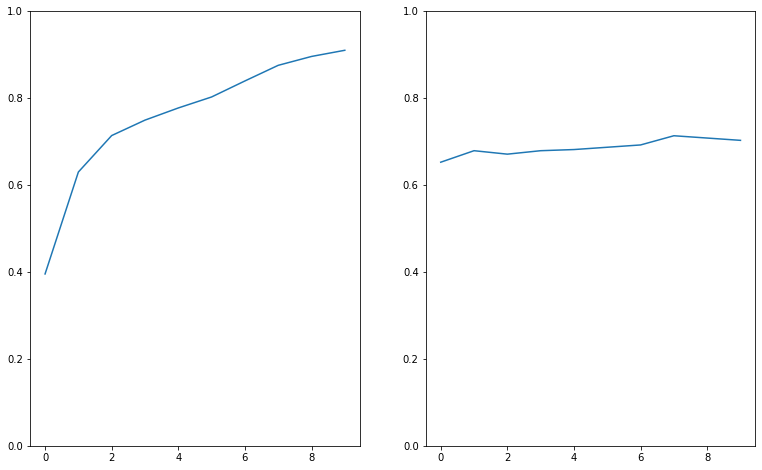

In [21]:
x = range(num_epochs)
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x,train_acc_list)
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.plot(x,test_acc_list)
plt.ylim(0,1)
plt.show()

In [22]:
print(train_acc_list)
print(test_acc_list)

[0.39514936409346346, 0.6295474711623787, 0.7133984028393988, 0.7488908606921054, 0.7768411712511116, 0.8021295474711646, 0.8389529724933463, 0.8748890860692109, 0.8952972493345166, 0.909494232475599]
[0.6521164021164018, 0.6785714285714284, 0.6706349206349207, 0.6785714285714283, 0.6812169312169308, 0.6865079365079362, 0.6917989417989417, 0.7129629629629631, 0.7076719576719578, 0.7023809523809524]
